<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Asset Management

### Machine Learning (Process)

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

http://tpq.io | [training@tpq.io](mailto:trainin@tpq.io) | [@dyjh](http://twitter.com/dyjh)


<img src="http://hilpisch.com/aiif_cover_shadow.png" width="35%" align="left">

## Machine Learning

Topics of interest include:

* learning
* success
* capacity
* evaluation
* bias & variance
* cross-validation

## Learning

<blockquote>"A computer program is said to learn from experience 𝐸 with respect to some class of tasks 𝑇 and performance measure 𝑃, if its performance at tasks in 𝑇, as measured by 𝑃, improves with experience 𝐸." — Mitchell (1997)</blockquote>


## Data

In [1]:
!git clone https://github.com/tpq-classes/python_for_asset_management.git
import sys
sys.path.append('python_for_asset_management')


Cloning into 'python_for_asset_management'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 155 (delta 120), reused 129 (delta 94), pack-reused 0 (from 0)
Receiving objects: 100% (155/155), 255.02 KiB | 6.22 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [2]:
!pip install scikeras

In [3]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
np.random.seed(100)
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

In [4]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [5]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)['EUR=']

In [6]:
raw.head()

,EUR=
Date,
2010-01-01,1.4323
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318


In [7]:
raw.tail()

,EUR=
Date,
2019-12-26,1.1096
2019-12-27,1.1175
2019-12-30,1.1197
2019-12-31,1.1210
2020-01-01,1.1210


In [8]:
l = raw.resample('1M').last()

/tmp/ipython-input-2373559149.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  l = raw.resample('1M').last()


In [9]:
l.tail()

,EUR=
Date,
2019-09-30,1.0898
2019-10-31,1.1150
2019-11-30,1.1015
2019-12-31,1.1210
2020-01-31,1.1210


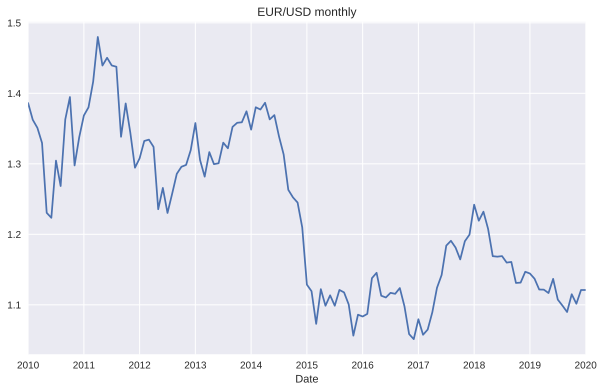

In [10]:
l.plot(figsize=(10, 6), title='EUR/USD monthly');

In [11]:
l = l.values
l -= l.mean()

In [12]:
f = np.linspace(-2, 2, len(l))

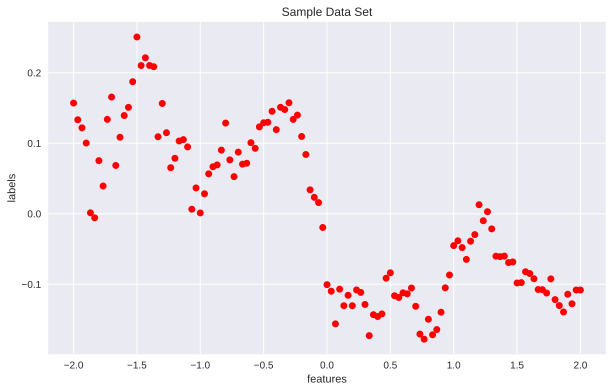

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro')
plt.title('Sample Data Set')
plt.xlabel('features')
plt.ylabel('labels');

## Success

In [14]:
def MSE(l, p):
    return np.mean((l - p) ** 2)

In [15]:
reg = np.polyfit(f, l, deg=5)
reg

array([-0.01910626, -0.0147182 ,  0.10990388,  0.06007211, -0.20833598,
       -0.03275423])

In [16]:
p = np.polyval(reg, f)

In [17]:
MSE(l, p)

np.float64(0.0034166422957371025)

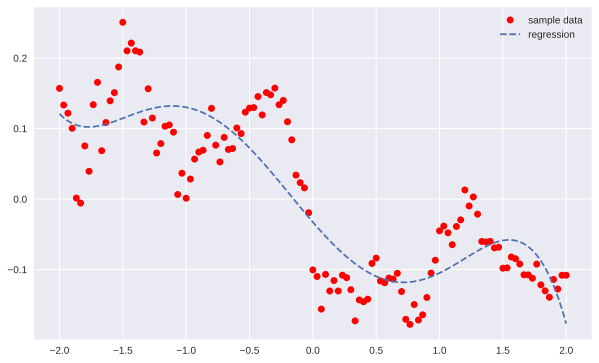

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='regression')
plt.legend();

In [19]:
%%time
for i in range(10, len(f) + 1, 20):
    reg = np.polyfit(f[:i], l[:i], deg=3)
    p = np.polyval(reg, f)
    mse = MSE(l, p)
    print(f'{i:3d} | MSE={mse}')

 10 | MSE=248628.10681642307
 30 | MSE=731.9382249304656
 50 | MSE=12.236088505004469
 70 | MSE=0.7410590619743299
 90 | MSE=0.005743061730409331
110 | MSE=0.006492800939555579
CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.83 ms


In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [21]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(100)

In [22]:
from keras.layers import Dense
from keras.models import Sequential

In [23]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=1))
model.add(Dense(1, activation='linear'))
model.compile(loss="mse", optimizer="rmsprop")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:

len(f)

121

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
h = model.fit(f, l, epochs=1500, verbose=False)

In [27]:
f

array([-2.        , -1.96666667, -1.93333333, -1.9       , -1.86666667,
       -1.83333333, -1.8       , -1.76666667, -1.73333333, -1.7       ,
       -1.66666667, -1.63333333, -1.6       , -1.56666667, -1.53333333,
       -1.5       , -1.46666667, -1.43333333, -1.4       , -1.36666667,
       -1.33333333, -1.3       , -1.26666667, -1.23333333, -1.2       ,
       -1.16666667, -1.13333333, -1.1       , -1.06666667, -1.03333333,
       -1.        , -0.96666667, -0.93333333, -0.9       , -0.86666667,
       -0.83333333, -0.8       , -0.76666667, -0.73333333, -0.7       ,
       -0.66666667, -0.63333333, -0.6       , -0.56666667, -0.53333333,
       -0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
       -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
       -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
        0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
        0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3 

In [28]:
p = model.predict(f).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [29]:
MSE(l, p)

np.float64(0.0022662432230786973)

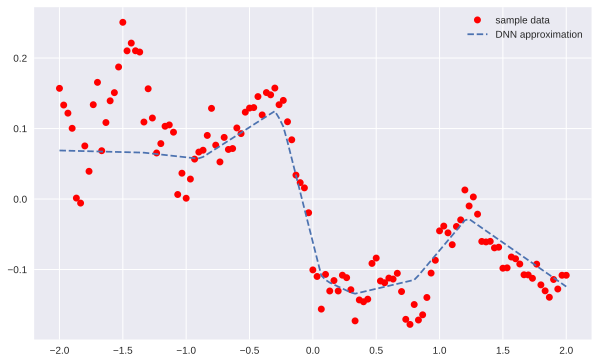

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();

In [31]:
import pandas as pd

In [32]:
res = pd.DataFrame(h.history)

In [33]:
res.tail()

,loss
1495,0.001978
1496,0.001982
1497,0.001963
1498,0.001967
1499,0.001985


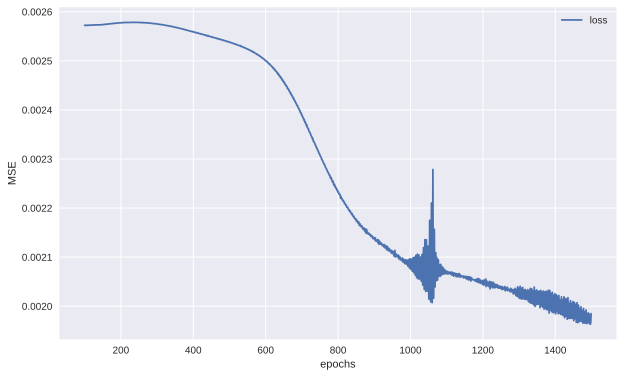

In [34]:
res.iloc[100:].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');

## Capacity

In [35]:
reg = {}
for d in range(1, 12, 2):
    reg[d] = np.polyfit(f, l, deg=d)
    p = np.polyval(reg[d], f)
    mse = MSE(l, p)
    print(f'{d:2d} | MSE={mse}')

 1 | MSE=0.005322474034260403
 3 | MSE=0.004353110724143182
 5 | MSE=0.0034166422957371025
 7 | MSE=0.0027389501772354004
 9 | MSE=0.0014119616263308448
11 | MSE=0.00126512378687523


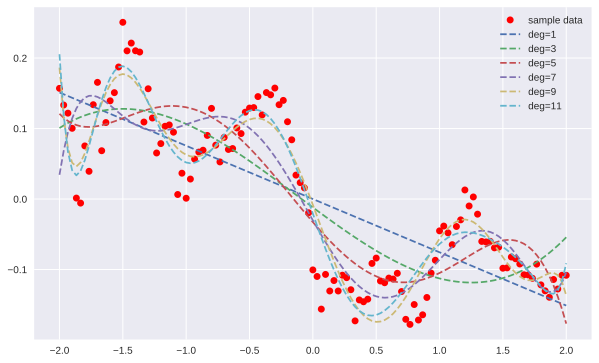

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
for d in reg:
    p = np.polyval(reg[d], f)
    plt.plot(f, p, '--', label=f'deg={d}')
plt.legend();

In [37]:
def create_dnn_model(hl=1, hu=256):
    ''' Function to create Keras DNN model.

    Parameters
    ==========
    hl: int
        number of hidden layers
    hu: int
        number of hidden units (per layer)
    '''
    model = Sequential()
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [38]:
model = create_dnn_model(3)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,353 (517.00 KB)

 Trainable params: 132,353 (517.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
%time model.fit(f, l, epochs=2500, verbose=False)

CPU times: user 2min 37s, sys: 6.28 s, total: 2min 43s
Wall time: 2min 37s


In [41]:
p = model.predict(f).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [42]:
MSE(l, p)

np.float64(0.0005230691657260502)

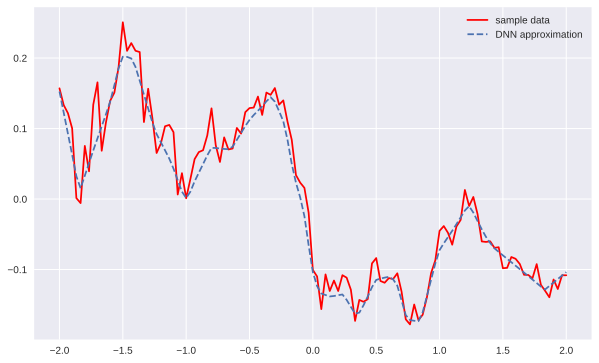

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'r', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();

## Evaluation

In [44]:
te = int(0.25 * len(f))
va = int(0.25 * len(f))

In [45]:
np.random.seed(100)
ind = np.arange(len(f))
np.random.shuffle(ind)

In [46]:
ind_te = np.sort(ind[:te])
ind_va = np.sort(ind[te:te + va])
ind_tr = np.sort(ind[te + va:])

In [47]:
f_te = f[ind_te]
f_va = f[ind_va]
f_tr = f[ind_tr]

In [48]:
l_te = l[ind_te]
l_va = l[ind_va]
l_tr = l[ind_tr]

In [49]:
reg = {}
mse = {}
for d in range(1, 22, 4):
    reg[d] = np.polyfit(f_tr, l_tr, deg=d)
    p = np.polyval(reg[d], f_tr)
    mse_tr = MSE(l_tr, p)
    p = np.polyval(reg[d], f_va)
    mse_va = MSE(l_va, p)
    mse[d] = (mse_tr, mse_va)
    print(f'{d:2d} | MSE_tr={mse_tr:7.5f} | MSE_va={mse_va:7.5f}')

 1 | MSE_tr=0.00574 | MSE_va=0.00492
 5 | MSE_tr=0.00375 | MSE_va=0.00273
 9 | MSE_tr=0.00132 | MSE_va=0.00243
13 | MSE_tr=0.00094 | MSE_va=0.00183
17 | MSE_tr=0.00060 | MSE_va=0.00153
21 | MSE_tr=0.00046 | MSE_va=0.00837


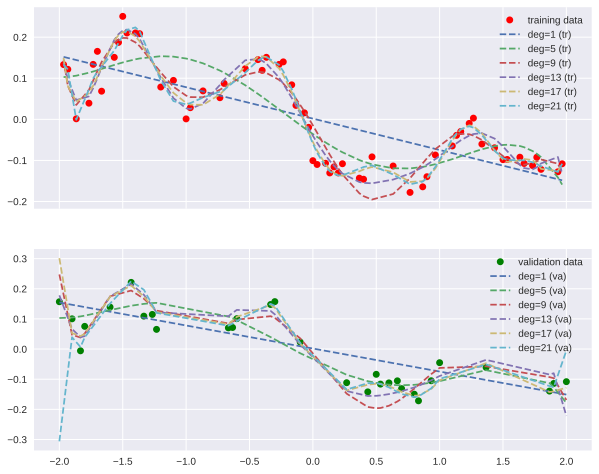

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
ax[1].plot(f_va, l_va, 'go', label='validation data')
for d in reg:
    p = np.polyval(reg[d], f_tr)
    ax[0].plot(f_tr, p, '--', label=f'deg={d} (tr)')
    p = np.polyval(reg[d], f_va)
    plt.plot(f_va, p, '--', label=f'deg={d} (va)')
ax[0].legend()
ax[1].legend();

In [51]:
from keras.callbacks import EarlyStopping

In [52]:
model = create_dnn_model(2, 256)

In [53]:
callbacks = [EarlyStopping(monitor='loss',
                           patience=100,
                          restore_best_weights=True)]

In [54]:
%%time
h = model.fit(f_tr, l_tr, epochs=3000, verbose=False,
          validation_data=(f_va, l_va),
          callbacks=callbacks)

CPU times: user 4min 48s, sys: 9.41 s, total: 4min 57s
Wall time: 5min 5s


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


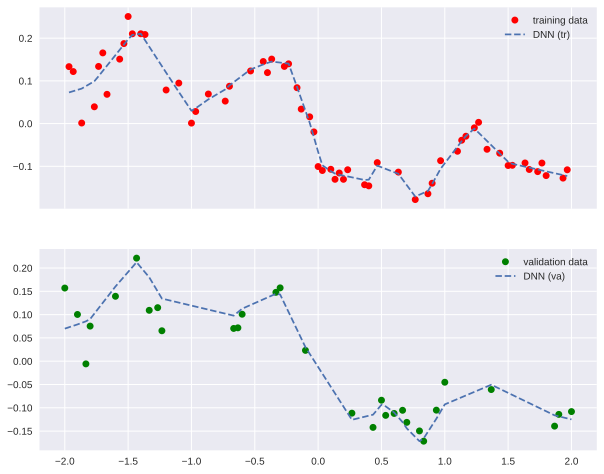

In [55]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
p = model.predict(f_tr)
ax[0].plot(f_tr, p, '--', label=f'DNN (tr)')
ax[0].legend()
ax[1].plot(f_va, l_va, 'go', label='validation data')
p = model.predict(f_va)
ax[1].plot(f_va, p, '--', label=f'DNN (va)')
ax[1].legend();

In [56]:
res = pd.DataFrame(h.history)

In [57]:
res.tail()

,loss,val_loss
2995,0.000666,0.001193
2996,0.000677,0.001210
2997,0.000694,0.001219
2998,0.000694,0.001213
2999,0.000680,0.001187


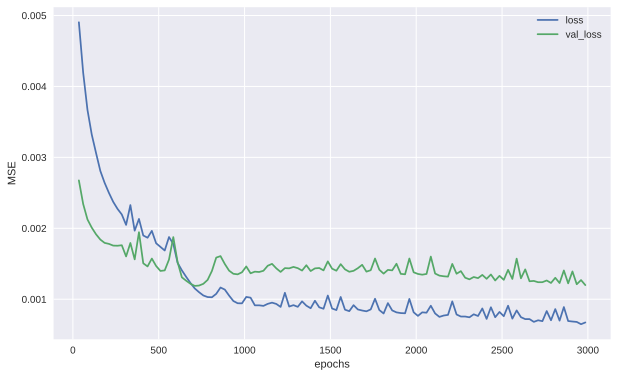

In [58]:
res.iloc[35::25].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');

In [59]:
p_ols = np.polyval(reg[5], f_te)
p_dnn = model.predict(f_te).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [60]:
MSE(l_te, p_ols)

np.float64(0.0038960346771028326)

In [61]:
MSE(l_te, p_dnn)

np.float64(0.0006333312792893458)

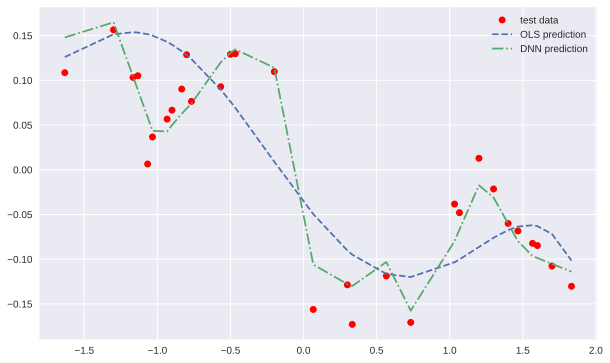

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(f_te, l_te, 'ro', label='test data')
plt.plot(f_te, p_ols, '--', label='OLS prediction')
plt.plot(f_te, p_dnn, '-.', label='DNN prediction');
plt.legend();

## Bias & Variance

In [63]:
f_tr = f[:20:2]
l_tr = l[:20:2]

In [64]:
f_va = f[1:20:2]
l_va = l[1:20:2]

In [65]:
reg_b = np.polyfit(f_tr, l_tr, deg=1)

In [66]:
reg_v = np.polyfit(f_tr, l_tr, deg=9, full=True)[0]

In [67]:
f_ = np.linspace(f_tr.min(), f_va.max(), 75)

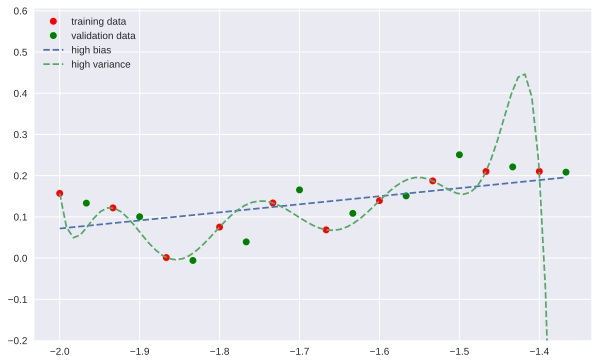

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(f_tr, l_tr, 'ro', label='training data')
plt.plot(f_va, l_va, 'go', label='validation data')
plt.plot(f_, np.polyval(reg_b, f_), '--', label='high bias')
plt.plot(f_, np.polyval(reg_v, f_), '--', label='high variance')
plt.ylim(-0.2)
plt.legend(loc=2);

In [69]:
from sklearn.metrics import r2_score

In [70]:
def evaluate(reg, f, l):
    p = np.polyval(reg, f)
    bias = np.abs(l - p).mean()
    var = p.var()
    msg = f'MSE={MSE(l, p):.4f} | R2={r2_score(l, p):9.4f} | '
    msg += f'bias={bias:.4f} | var={var:.4f}'
    print(msg)

In [71]:
evaluate(reg_b, f_tr, l_tr)

MSE=0.0026 | R2=   0.3484 | bias=0.0423 | var=0.0014


In [72]:
evaluate(reg_b, f_va, l_va)

MSE=0.0032 | R2=   0.4498 | bias=0.0460 | var=0.0014


In [73]:
evaluate(reg_v, f_tr, l_tr)

MSE=0.0000 | R2=   1.0000 | bias=0.0000 | var=0.0040


In [74]:
evaluate(reg_v, f_va, l_va)

MSE=0.8752 | R2=-149.2664 | bias=0.3565 | var=0.7539


## Cross-Validation

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [76]:
def PolynomialRegression(degree=None, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [77]:
np.set_printoptions(suppress=True,
        formatter={'float': lambda x: f'{x:12.2f}'})

In [78]:
print('\nCross-validation scores')
print(74 * '=')
for deg in range(0, 10, 1):
    model = PolynomialRegression(deg)
    cvs = cross_val_score(model, f.reshape(-1, 1), l, cv=5)
    print(f'deg={deg} | ' + str(cvs.round(2)))


Cross-validation scores
deg=0 | [       -6.07        -7.34        -0.09        -6.32        -8.69]
deg=1 | [       -0.28        -1.40         0.16        -1.66        -4.62]
deg=2 | [       -3.48        -2.45         0.19        -1.57       -12.94]
deg=3 | [       -0.00        -1.24         0.32        -0.48       -43.62]
deg=4 | [     -222.81        -2.88         0.37        -0.32      -496.61]
deg=5 | [     -143.67        -5.85         0.49         0.12     -1241.04]
deg=6 | [    -4038.96       -14.71         0.49        -0.33      -317.32]
deg=7 | [    -9937.83       -13.98         0.64         0.22    -18725.61]
deg=8 | [    -3514.36       -11.22        -0.15        -6.29   -298744.18]
deg=9 | [    -7454.15        -0.91         0.15        -0.41    -13580.75]


In [79]:
np.random.seed(100)
tf.random.set_seed(100)
from scikeras.wrappers import KerasRegressor

In [80]:
model = KerasRegressor(model=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=1, hu=36)

In [81]:
%time cross_val_score(model, f.reshape(-1, 1), l, cv=5)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [82]:
model = KerasRegressor(model=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=3, hu=256)

In [83]:
%time cross_val_score(model, f.reshape(-1, 1), l, cv=5)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>